# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [47]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from palmerpenguins import load_penguins
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from plotnine import ggplot,aes,geom_point,geom_smooth,labs,geom_line,scale_color_manual
peng = load_penguins().dropna()
peng.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [49]:
y = peng['bill_depth_mm']
X = peng.drop(['bill_depth_mm'],axis=1)

In [50]:
ct = ColumnTransformer(
  [
    ("dummify", #Dummifying variables that need it
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'), #If we haven't trained on a column, don't use for predicting on test validation
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* kNN models (for different values of K)
* Decision tree models (for different complexities)

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted against the model complexity.

Which of your models was best?

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

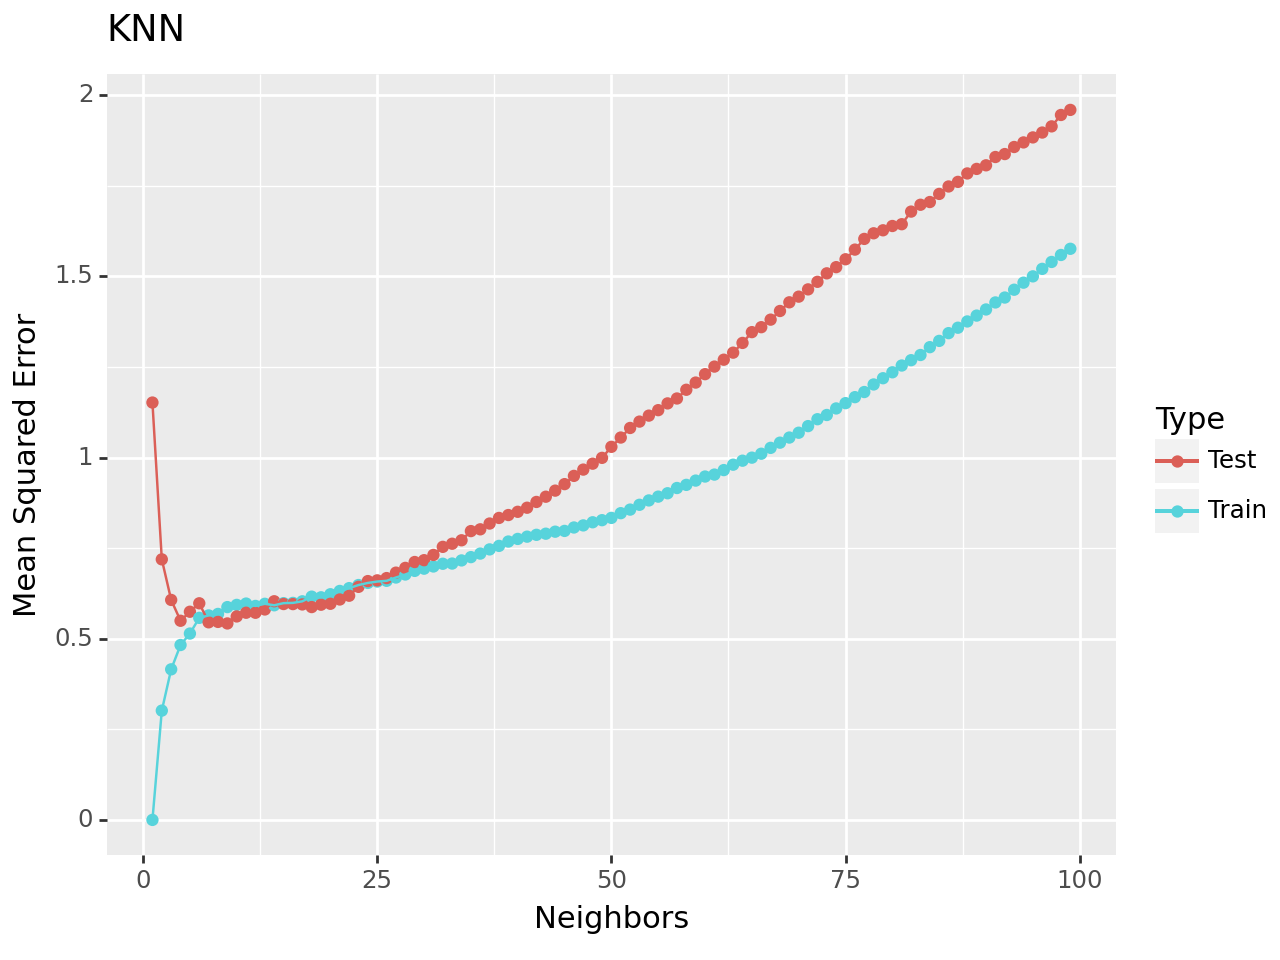

<Figure Size: (640 x 480)>

In [84]:
mses = []
testtypes = []
ks = []
for k in range(1,100,1):
    pipe_knn = Pipeline(
      [("preprocessing", ct),
      ("model", KNeighborsRegressor(n_neighbors=k))]
    )
    pipe_knn.fit(X_train, y_train)

    mses.append(mean_squared_error(y_train, y_pred = pipe_knn.predict(X_train)))
    testtypes.append("Train")
    ks.append(k)
    
    mses.append(mean_squared_error(y_test, y_pred = pipe_knn.predict(X_test)))
    testtypes.append("Test")
    ks.append(k)

df = pd.DataFrame({"Neighbors":ks,"MSE":mses,"Type":testtypes})
(ggplot(df, aes(x='Neighbors', y='MSE', color='Type'))
        + labs(x='Neighbors', y='Mean Squared Error', title='KNN')
        + geom_point()
        + geom_line()
        )#aes(x='Neighbors', y='MSE'),color='black'

The graph here is a bit inverted, so a low neighbor value is a high complexity and high neighbor is lower complexity. So, as we decrease neighbors from 100 the MSE continues to gradually decrease until we definitely overfit it at low values around 5-8.

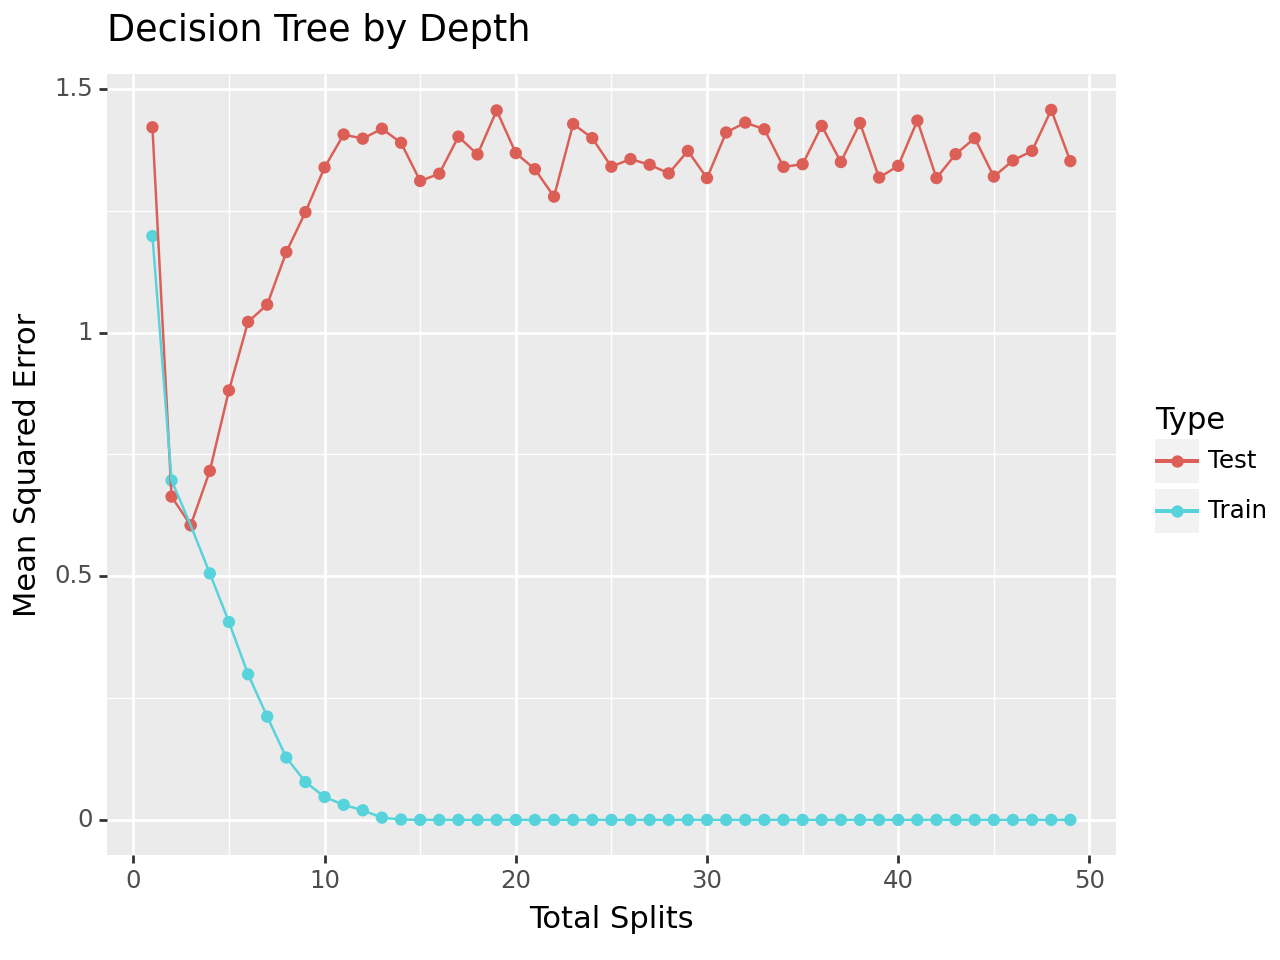

<Figure Size: (640 x 480)>

In [85]:
mses = []
testtypes = []
ns = []
for n in range(1,50,1):
    pipe_dec = Pipeline(
      [("preprocessing", ct),
      ("model", DecisionTreeRegressor(max_depth=n))]
    )
    pipe_dec.fit(X_train, y_train)

    mses.append(mean_squared_error(y_train, y_pred = pipe_dec.predict(X_train)))
    testtypes.append("Train")
    ns.append(n)
    
    mses.append(mean_squared_error(y_test, y_pred = pipe_dec.predict(X_test)))
    testtypes.append("Test")
    ns.append(n)

df = pd.DataFrame({"Total Splits":ns,"MSE":mses,"Type":testtypes})
(ggplot(df, aes(x='Total Splits', y='MSE', color='Type'))
        + labs(x='Total Splits', y='Mean Squared Error', title='Decision Tree by Depth')
        + geom_point()
        + geom_line()
        )#aes(x='Neighbors', y='MSE'),color='black'

These results clearly show how with enough splitting the decision tree can perfectly predict values, because the splits have few or just 1 point to use to guess the value from. So, after a split of 3 the MSE simply continues to rise for the test split because it's become overfit more and more to the training data.

### Best?

It doesn't seem like between these two models one is significantly better than the other. Both converge to a non-overfit model around an MSE of .6. In that case we might like the decision tree because of it's interpretability.

### Extra Decision Tree Observing

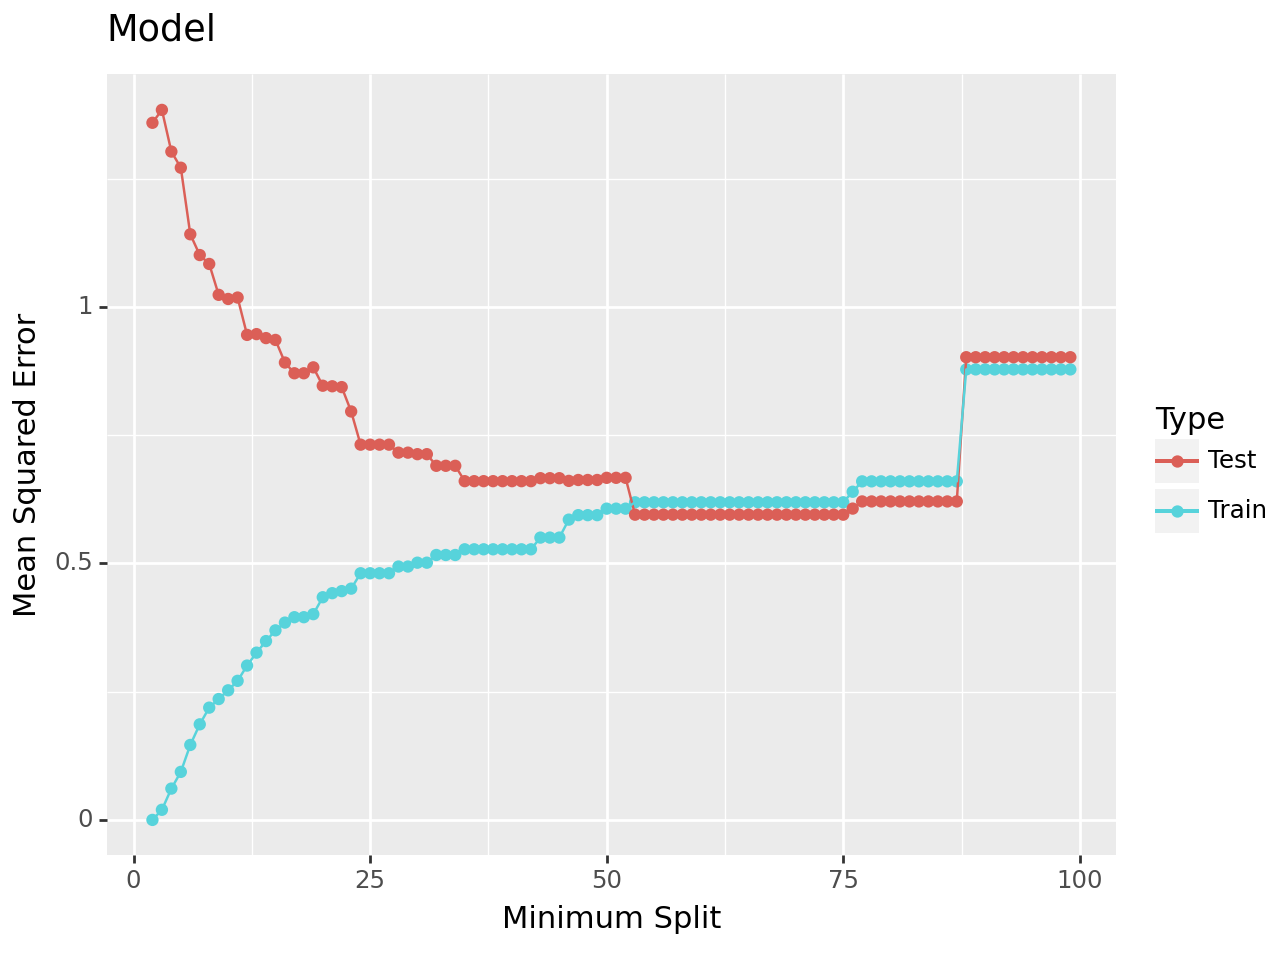

<Figure Size: (640 x 480)>

In [81]:
mses = []
testtypes = []
ns = []
for n in range(2,100,1):
    pipe_dec = Pipeline(
      [("preprocessing", ct),
      ("model", DecisionTreeRegressor(min_samples_split=n))]
    )
    pipe_dec.fit(X_train, y_train)

    mses.append(mean_squared_error(y_train, y_pred = pipe_dec.predict(X_train)))
    testtypes.append("Train")
    ns.append(n)
    
    mses.append(mean_squared_error(y_test, y_pred = pipe_dec.predict(X_test)))
    testtypes.append("Test")
    ns.append(n)

df = pd.DataFrame({"Min Split":ns,"MSE":mses,"Type":testtypes})
(ggplot(df, aes(x='Min Split', y='MSE', color='Type'))
        + labs(x='Minimum Split', y='Mean Squared Error', title='Model')
        + geom_point()
        + geom_line()
        )#aes(x='Neighbors', y='MSE'),color='black'

In [80]:
a = df[df['Type'] == "Test"]
a.sort_values(by=['MSE'])

,Min Samples,MSE,Type
133,68,0.595168,Test
129,66,0.595168,Test
135,69,0.595168,Test
105,54,0.595168,Test
115,59,0.595168,Test
...,...,...,...
9,6,1.152721,Test
7,5,1.280826,Test
5,4,1.329094,Test
3,3,1.359196,Test


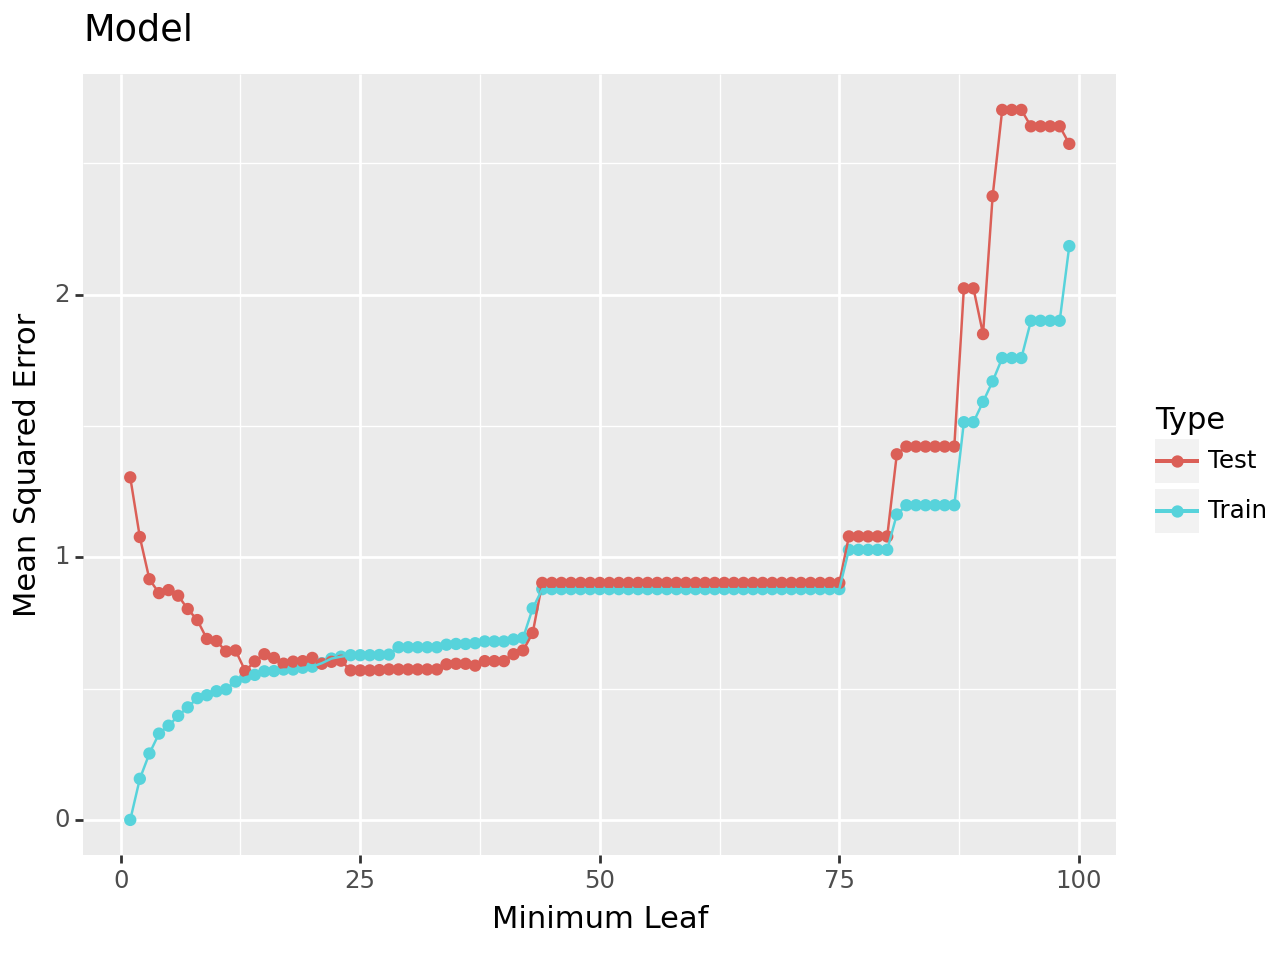

<Figure Size: (640 x 480)>

In [83]:
#Use best samples split, now test min leafs
mses = []
testtypes = []
ns = []
for n in range(1,100,1):
    pipe_dec = Pipeline(
      [("preprocessing", ct),
      ("model", DecisionTreeRegressor(min_samples_leaf=n))]
    )
    pipe_dec.fit(X_train, y_train)

    mses.append(mean_squared_error(y_train, y_pred = pipe_dec.predict(X_train)))
    testtypes.append("Train")
    ns.append(n)
    
    mses.append(mean_squared_error(y_test, y_pred = pipe_dec.predict(X_test)))
    testtypes.append("Test")
    ns.append(n)

df = pd.DataFrame({"Min Leaf":ns,"MSE":mses,"Type":testtypes})
(ggplot(df, aes(x='Min Leaf', y='MSE', color='Type'))
        + labs(x='Minimum Leaf', y='Mean Squared Error', title='Model')
        + geom_point()
        + geom_line()
        )#aes(x='Neighbors', y='MSE'),color='black'